# Study Limitations of Lognormal Modeling in the PMI Methodology

---

*Purpose*: The PMI assumes lognormal marginal distributions to provide analytic expressions. What is the consequence of this assumption? The purpose of this computational essay is to probe the limitations of the lognormal assumption.

Below, we shall see that the lognormal approximation tends to be accurate in cases where the underlying variability is small, as measured by the coefficient of variation (COV). Larger departures occur at higher variabilities, but within a typical range of COV's encountered in aerospace-grade materials, the departures are acceptable for conceptual design purposes.


In [1]:
import grama as gr
import numpy as np
import pandas as pd
from plotnine import *

DF = gr.Intention()

## Construct beam problem

Construct the strength-constrained beam problem


In [2]:
## Set fixed parameters globally
l = 1      # Beam length
f = 1      # Applied tip load
rho = 1    # Material density
beta_t = 3 # Target reliability index

# Independent strength parameters
median_strength = 1 
cov_strength = 0.1
# Dependent parameters
mu_strength = np.log(median_strength)
sig_strength = cov_strength


In [3]:
md_strength_lognorm = (
    gr.Model("Strength constraint, lognormal marginals")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            g_strength=(df.t**3 * df.sigma_y) / (6 * f * l) - 1,
        ),
        var=["t", "sigma_y"],
        out=["g_strength"],
    )
    >> gr.cp_bounds(t=(0, 1))
    >> gr.cp_marginals(
        sigma_y=dict(dist="lognorm", loc=0, scale=median_strength, s=cov_strength, sign=-1),
    )
    >> gr.cp_copula_independence()
)
md_strength_lognorm


model: Strength constraint, lognormal marginals

  inputs:
    var_det:
      t: [0, 1]

    var_rand:
      sigma_y: (-1) lognorm, {'loc': 0, 'scale': 1, 's': 0.1}

    copula:
      Independence copula

  functions:
      f0: ['t', 'sigma_y'] -> ['g_strength']

Create nested model using FORM PMA to approximate the reliability constraint


In [4]:
md_beam = (
    gr.Model("Beam")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            cost=l * df.t**2 * rho,
        ),
        var=["t"],
        out=["cost"]
    )
    >> gr.cp_vec_function(
        fun=lambda df: 
            md_strength_lognorm
            >> gr.ev_form_pma(
                betas=dict(g_strength=beta_t),
                df_det=df,
            ),
        var=["t"],
        out=["g_strength"]
    )
    >> gr.cp_bounds(t=(0.1, 5))
)
md_beam

model: Beam

  inputs:
    var_det:
      t: [0.1, 5]

    var_rand:

    copula:
      None

  functions:
      f0: ['t'] -> ['cost']
      f1: ['t'] -> ['g_strength']

## Compare computational approach with exact solution

---

First, run the optimization


In [5]:
df_opt = (
    md_beam
    >> gr.ev_min(
        out_min="cost",
        out_geq=["g_strength"],
    )
)
t_opt = df_opt.t[0]
df_opt


,t,t_0,cost,g_strength,success,message,n_iter
0,2.008229,2.55,4.032983,-3.566702e-11,True,Optimization terminated successfully,5


Next, compute using exact solution


In [6]:
g0 = 1 / (6 * f * l)
w_s = -1
q = -3
mu_w = w_s * mu_strength
sig_w = np.sqrt(w_s**2 * sig_strength**2)

# Median design
t_mmi = (g0 * np.exp(-mu_w)) ** (1/q)
# Reliability factor
f_rmi = np.exp(-beta_t * sig_w) ** (1/q)

# Compute reliability-optimized design
t_rmi = t_mmi * f_rmi
t_rmi

2.008228833834461

Note that the FORM-approximated and exact solution match.


In [7]:
print("Optimized t: {0:4.3f}".format(t_opt))
print("Exact t:     {0:4.3f}".format(t_rmi))
print("Diff: {0:4.3f} %".format(100 * (t_rmi - t_opt) / t_opt))


Optimized t: 2.008
Exact t:     2.008
Diff: 0.000 %


## Probe Lognormal Modeling Limitations

---

*Hypothesis*: At small variances, the lognormal approximation will be relatively accurate.


### Single comparison

Set up a model with a normal marginal, 10% COV.


In [8]:
md_strength_norm = (
    gr.Model("Strength constraint, normal marginals")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            g_strength=(df.t**3 * df.sigma_y) / (6 * f * l) - 1,
        ),
        var=["t", "sigma_y"],
        out=["g_strength"],
    )
    >> gr.cp_marginals(
        sigma_y=dict(dist="norm", loc=1, scale=0.1, sign=-1),
    )
    >> gr.cp_copula_independence()
)
print(md_strength_norm)

md_beam_norm = (
    gr.Model("Beam, normal marginal")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            cost=l * df.t**2 * rho,
        ),
        var=["t"],
        out=["cost"]
    )
    >> gr.cp_vec_function(
        fun=lambda df: 
            md_strength_norm
            >> gr.ev_form_pma(
                betas=dict(g_strength=beta_t),
                df_det=df,
            ),
        var=["t"],
        out=["g_strength"]
    )
    >> gr.cp_bounds(t=(0.1, 5))
)
print(md_beam_norm)

model: Strength constraint, normal marginals

  inputs:
    var_det:
      t: (unbounded)

    var_rand:
      sigma_y: (-1) norm, {'loc': 1, 'scale': 0.1}

    copula:
      Independence copula

  functions:
      f0: ['t', 'sigma_y'] -> ['g_strength']

model: Beam, normal marginal

  inputs:
    var_det:
      t: [0.1, 5]

    var_rand:

    copula:
      None

  functions:
      f0: ['t'] -> ['cost']
      f1: ['t'] -> ['g_strength']



Run FORM PMA to optimize the model, respecting its true marginal


In [9]:
df_opt_norm = (
    md_beam_norm
    >> gr.ev_min(
        out_min="cost",
        out_geq=["g_strength"],
    )
)
t_opt_norm = df_opt_norm.t[0]
df_opt_norm


,t,t_0,cost,g_strength,success,message,n_iter
0,2.046528,2.55,4.188278,-7.843504e-11,True,Optimization terminated successfully,5


Apply lognormal approximation using PMI methodology


In [10]:
## Generate a sample for parameter estimation
df_norm_sample = (
    md_strength_norm  
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", skip=True)
    >> gr.tf_summarize(
        mu_strength=gr.mean(gr.log(DF.sigma_y)),
        sig_strength=gr.sd(gr.log(DF.sigma_y)),
    )
)

# Extract parameter values
mu_strength = df_norm_sample.mu_strength[0]
sig_strength = df_norm_sample.sig_strength[0]
mu_w = w_s * mu_strength
sig_w = np.sqrt(w_s**2 * sig_strength**2)

# Median design
t_mmi_norm = (g0 * np.exp(-mu_w)) ** (1/q)
# Reliability factor
f_rmi_norm = np.exp(-beta_t * sig_w) ** (1/q)

# Compute reliability-optimized design
t_rmi_norm = t_mmi_norm * f_rmi_norm
t_rmi_norm

eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


2.020401865340321

This single run agrees with the hypothesis; at a small variability (COV 10%) the lognormal approximation does not significantly alter the design.


In [11]:
print("Optimized t: {0:4.3f}".format(t_opt_norm))
print("Lognorm t:   {0:4.3f}".format(t_rmi_norm))
print("Diff: {0:4.3f} %".format(100 * (t_opt_norm - t_rmi_norm) / t_opt_norm))


Optimized t: 2.047
Lognorm t:   2.020
Diff: 1.277 %


### Sweep comparison

Repeat the process above for a range of variabilities


In [12]:
# Helper function to carry out comparison at different COV values
def eval_cov(cov):
    ## Set up model with desired COV
    md_strength_norm = (
        gr.Model("Strength constraint, normal marginals")
        >> gr.cp_vec_function(
            fun=lambda df: gr.df_make(
                g_strength=(df.t**3 * df.sigma_y) / (6 * f * l) - 1,
            ),
            var=["t", "sigma_y"],
            out=["g_strength"],
        )
        >> gr.cp_marginals(
            sigma_y=dict(dist="norm", loc=1, scale=cov, sign=-1),
        )
        >> gr.cp_copula_independence()
    )
    md_beam_norm = (
        gr.Model("Beam, normal marginal")
        >> gr.cp_vec_function(
            fun=lambda df: gr.df_make(
                cost=l * df.t**2 * rho,
            ),
            var=["t"],
            out=["cost"]
        )
        >> gr.cp_vec_function(
            fun=lambda df: 
                md_strength_norm
                >> gr.ev_form_pma(
                    betas=dict(g_strength=beta_t),
                    df_det=df,
                ),
            var=["t"],
            out=["g_strength"]
        )
        >> gr.cp_bounds(t=(0.1, 5))
    )
    
    ## Optimization respecting the marginal
    df_opt_norm = (
        md_beam_norm
        >> gr.ev_min(
            out_min="cost",
            out_geq=["g_strength"],
        )
    )
    t_opt_norm = df_opt_norm.t[0]
    
    ## Optimization using lognormal approximation
    df_norm_sample = (
        md_strength_norm  
        >> gr.ev_monte_carlo(n=1e3, df_det="nom", skip=True, seed=101)
        >> gr.tf_summarize(
            mu_strength=gr.mean(gr.log(DF.sigma_y)),
            sig_strength=gr.sd(gr.log(DF.sigma_y)),
        )
    )
    
    # Extract parameter values
    mu_strength = df_norm_sample.mu_strength[0]
    sig_strength = df_norm_sample.sig_strength[0]
    mu_w = w_s * mu_strength
    sig_w = np.sqrt(w_s**2 * sig_strength**2)
    
    # Median design
    t_mmi_norm = (g0 * np.exp(-mu_w)) ** (1/q)
    # Reliability factor
    f_rmi_norm = np.exp(-beta_t * sig_w) ** (1/q)
    
    # Compute reliability-optimized design
    t_rmi_norm = t_mmi_norm * f_rmi_norm
    t_rmi_norm
    
    ## Return the results
    return gr.df_make(
        cov=cov,
        t_opt=t_opt_norm,
        t_rmi=t_rmi_norm,
    )


Carry out the sweep


In [13]:
df_sweep = pd.DataFrame()

for cov in (0.01, 0.05, 0.1, 0.2, 0.3):
    df_tmp = eval_cov(cov)
    df_sweep = pd.concat((df_sweep, df_tmp), axis=0)
df_sweep


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


,cov,t_opt,t_rmi
0,0.01,1.835664,1.835572
0,0.05,1.918275,1.912323
0,0.10,2.046528,2.016679
0,0.20,2.466212,2.271371
0,0.30,3.914868,2.792139


Visualize the results


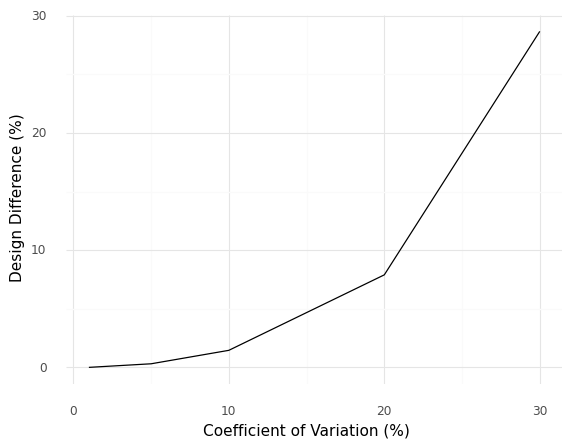

<ggplot: (8792661294324)>

In [14]:
(
    df_sweep
    >> gr.tf_mutate(diff=(DF.t_opt - DF.t_rmi) / DF.t_opt)
    
    >> ggplot(aes("100 * cov", "100 * diff"))
    + geom_line()
    + theme_minimal()
    + labs(
        x="Coefficient of Variation (%)",
        y="Design Difference (%)",
    )
)

We can see that the difference in designs varies slowly at small COV values, but begins to depart rapidly at higher COV values. This implies that the lognormal approximation is unsafe to apply in high-variability settings. However, it is important to recall that a $\text{COV} = 30\%$ is unrealistic; aircraft-grade metals typically have $\text{COV} \leq 5\%$, and even the most variable composite properties have $\text{COV} \approx 20\%$. Based on the results above, such variabilities place the design difference in the range of $d = \pm 10\%$, which is acceptable for conceptual design purposes.
